In [18]:
import ktrain
from ktrain import text
import pandas as pd
import random
import numpy as np
import math

In [19]:
csv_file = '../../data/merged_ktrain_google_en.csv'
data = pd.read_csv(csv_file).values
print(len(data))

21589


In [20]:
epochs = 3
learning_rate = 5e-5
batch_size = 32
max_length = 21
max_words = 25000

In [21]:
def split_test_data(data, split=0.1, random_seed=42):
    np.random.seed(random_seed)
    np.random.shuffle(data)
    split_item = math.floor(split * len(data))
    print('split at: ', split_item)
    x_test, y_test = data[:split_item, 0], data[:split_item, 1:]
    x_train, y_train = data[split_item:, 0], data[split_item:, 1:]
    return x_train, y_train, x_test, y_test

In [22]:
x_train, y_train, x_val, y_val = split_test_data(data, split=0.05, random_seed=4242)
print(len(x_train), len(y_train), len(x_val), len(y_val))

split at:  1079
20510 20510 1079 1079


In [23]:
from sklearn.utils import class_weight
def generate_balanced_weights(y_train):
    y_labels = [y.argmax() for y in y_train]
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_labels), y_labels)
    weight_dict = {}
    for key in range(len(class_weights)):
        weight_dict[key] = class_weights[key]
    return weight_dict

class_weight_dict = generate_balanced_weights(y_train)
print(class_weight_dict)

{0: 2.1765891966465034, 1: 0.49869915140905, 2: 1.8679417122040072}


In [24]:
MODEL = 'distilbert-base-uncased'
transformer = text.Transformer(MODEL, maxlen=max_length, class_names=['less', 'equal', 'more'])
train_data = transformer.preprocess_train(x_train, y_train)
val_data = transformer.preprocess_test(x_val, y_val)

preprocessing train...
language: en
train sequence lengths:
	mean : 9
	95percentile : 15
	99percentile : 18


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 9
	95percentile : 15
	99percentile : 19


In [25]:
model = transformer.get_classifier()

In [26]:
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=batch_size)

In [27]:
learner.lr_find(show_plot=True, max_epochs=2)

simulating training for different learning rates... this may take a few moments...
Train for 640 steps
Epoch 1/2
  0/640 [..............................] - ETA: 0s

KeyError: 'loss'

In [31]:
learner.fit_onecycle(5e-5, epochs=10, class_weight=class_weight_dict)



begin training using onecycle policy with max lr of 5e-05...
Train for 641 steps, validate for 34 steps
Epoch 1/10
641/641 [==============================] - 44s 69ms/step - loss: 0.1983 - accuracy: 0.9109 - val_loss: 2.5230 - val_accuracy: 0.6024
Epoch 2/10
641/641 [==============================] - 43s 67ms/step - loss: 0.1542 - accuracy: 0.9302 - val_loss: 2.6559 - val_accuracy: 0.5598
Epoch 3/10
641/641 [==============================] - 43s 67ms/step - loss: 0.1353 - accuracy: 0.9361 - val_loss: 2.6037 - val_accuracy: 0.5366
Epoch 4/10
641/641 [==============================] - 44s 68ms/step - loss: 0.1307 - accuracy: 0.9396 - val_loss: 2.7147 - val_accuracy: 0.5700
Epoch 5/10
641/641 [==============================] - 43s 68ms/step - loss: 0.1452 - accuracy: 0.9360 - val_loss: 2.6686 - val_accuracy: 0.5468
Epoch 6/10
641/641 [==============================] - 43s 67ms/step - loss: 0.1190 - accuracy: 0.9481 - val_loss: 3.0406 - val_accuracy: 0.5440
Epoch 7/10
641/641 [==========

In [11]:
learner.view_top_losses(n=10, preproc=transformer)

----------
id:783 | loss:7.45 | true:more | pred:equal)

----------
id:548 | loss:7.33 | true:more | pred:equal)

----------
id:375 | loss:7.3 | true:more | pred:equal)

----------
id:966 | loss:7.13 | true:more | pred:equal)

----------
id:907 | loss:7.08 | true:more | pred:equal)

----------
id:742 | loss:7.07 | true:more | pred:equal)

----------
id:143 | loss:7.04 | true:more | pred:equal)

----------
id:412 | loss:7.04 | true:more | pred:equal)

----------
id:0 | loss:7.02 | true:more | pred:equal)

----------
id:994 | loss:6.95 | true:more | pred:equal)



In [12]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)

In [13]:
predictor.explain(x_train[741])

In [32]:
confusion = learner.evaluate()

              precision    recall  f1-score   support

           0       0.22      0.20      0.21       156
           1       0.70      0.76      0.73       727
           2       0.28      0.21      0.24       196

    accuracy                           0.58      1079
   macro avg       0.40      0.39      0.39      1079
weighted avg       0.55      0.58      0.57      1079



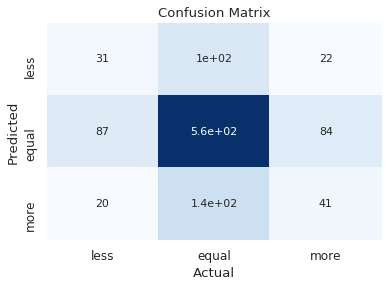

In [33]:
# print confusion matrix
import matplotlib.pyplot as plt
import seaborn as sn
labels = ['less', 'equal', 'more']
cm_df = pd.DataFrame(confusion, labels, labels)
sn.set(font_scale=1.1, font='Arial')
ax = sn.heatmap(cm_df, cmap="Blues", annot=True, annot_kws={"size": 11}, cbar=False)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title("Confusion Matrix")
plt.show()